### LIBRARIES USED

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

### DATA READING

In [2]:
df = pd.read_csv("C:\\Users\\MMU50\\OneDrive\\Desktop\\FYP_Cleaned.csv", na_values=[], keep_default_na=False)

C:\Users\MMU50\AppData\Local\Temp\ipykernel_29872\2874260836.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:\\Users\\MMU50\\OneDrive\\Desktop\\FYP_Cleaned.csv", na_values=[], keep_default_na=False)


### DATA CLEANING

In [3]:
# =============== Encoding ============== #

#A1Cresult & max_glu_serum

glu_map = {
    'None': 0,
    'Norm': 1,
    '>200': 2,
    '>300': 3
}

a1c_map = {
    'None': 0,
    'Norm': 1,
    '>7': 2,
    '>8': 3
}

df['max_glu_serum'] = df['max_glu_serum'].map(glu_map)
df['A1Cresult'] = df['A1Cresult'].map(a1c_map)

#Drug names

drug_map = {
    'No': 0,
    'Down': 1,
    'Steady': 2,
    'Up': 3
}

keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 
        'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 
        'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone', 'metformin-rosiglitazone', 
        'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']

for col in keys:
    df[col] = df[col].map(drug_map)


# ============== Removing Missing Values ============= #

df = df[df['discharge_disposition_id'].astype(str).str.strip() != '']

# ============= Change Column Type ================= #

df['discharge_disposition_id'] = pd.to_numeric(df['discharge_disposition_id'], errors='coerce')

# ================ Dropping Column ================ #

df = df.drop(columns=["patient_nbr"])

### TRAIN-TEST SPLIT

In [4]:
 # =============== Feature & Target Split ============== #

X = df.drop(columns=['readmitted'])  
y = df['readmitted']

# =============== Train-Test Split ==================== #

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### MODEL BUILDING

CATBOOST

In [5]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
import joblib
import os
import numpy as np

# ========== Define Paths ==========
model_path = r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\BaseModels\catboost.pkl"
metrics_dir = r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\BaseModelMetrics"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True)

# ========== Train CatBoost ==========
cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)

# ========== Predict ==========
y_pred_cat = cat_model.predict(X_test)
y_proba_cat = cat_model.predict_proba(X_test)[:, 1]

# ========== Evaluation ==========
accuracy = accuracy_score(y_test, y_pred_cat)
roc_auc = roc_auc_score(y_test, y_proba_cat)
report = classification_report(y_test, y_pred_cat, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred_cat)

# ========== ROC Curve Data ==========
fpr, tpr, thresholds = roc_curve(y_test, y_proba_cat)

# ========== Print to Console ==========
print("🔹 CatBoost Classification Report:")
print(classification_report(y_test, y_pred_cat))
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# ========== Save Model ==========
joblib.dump(cat_model, model_path)
print(f"✅ Model saved to: {model_path}")

# ========== Save Metrics ==========
metrics_dict = {
    "classification_report": report,
    "confusion_matrix": conf_matrix,
    "accuracy": accuracy,
    "roc_auc": roc_auc,
    "roc_curve": {
        "fpr": fpr.tolist(),
        "tpr": tpr.tolist(),
        "thresholds": thresholds.tolist()
    }
}

metrics_path = os.path.join(metrics_dir, "catboost_base_metrics.pkl")
joblib.dump(metrics_dict, metrics_path)
print(f"📁 Metrics saved to: {metrics_path}")



🔹 CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.83     10970
           1       0.84      0.72      0.78      9378

    accuracy                           0.81     20348
   macro avg       0.82      0.80      0.80     20348
weighted avg       0.81      0.81      0.81     20348

Accuracy: 0.8091
ROC AUC: 0.8689
✅ Model saved to: C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\BaseModels\catboost.pkl
📁 Metrics saved to: C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\BaseModelMetrics\catboost_base_metrics.pkl


LIGHTGBM

In [7]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
import joblib
import os
import numpy as np

# ========== Define Paths ==========
model_path = r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\BaseModels\lightgbm.pkl"
metrics_dir = r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\BaseModelMetrics"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True)

# ========== Train LightGBM ==========
lgb = LGBMClassifier(random_state=42)
lgb.fit(X_train, y_train)

# ========== Predict ==========
y_pred_lgb = lgb.predict(X_test)
y_proba_lgb = lgb.predict_proba(X_test)[:, 1]

# ========== Evaluation ==========
accuracy = accuracy_score(y_test, y_pred_lgb)
roc_auc = roc_auc_score(y_test, y_proba_lgb)
report = classification_report(y_test, y_pred_lgb, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred_lgb)

# ========== ROC Curve Data ==========
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lgb)

# ========== Print to Console ==========
print("🔹 LightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgb))
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# ========== Save Model ==========
joblib.dump(lgb, model_path)
print(f"✅ Model saved to: {model_path}")

# ========== Save Metrics ==========
metrics_dict = {
    "report": report,
    "confusion_matrix": conf_matrix,
    "accuracy": accuracy,
    "roc_auc": roc_auc,
    "roc_curve": {
        "fpr": fpr.tolist(),
        "tpr": tpr.tolist(),
        "thresholds": thresholds.tolist()
    }
}

metrics_path = os.path.join(metrics_dir, "lightgbm_base_metrics.pkl")
joblib.dump(metrics_dict, metrics_path)
print(f"📁 Metrics saved to: {metrics_path}")


[LightGBM] [Info] Number of positive: 37509, number of negative: 43879
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 393
[LightGBM] [Info] Number of data points in the train set: 81388, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.460866 -> initscore=-0.156855
[LightGBM] [Info] Start training from score -0.156855
🔹 LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83     10970
           1       0.85      0.71      0.77      9378

    accuracy                           0.81     20348
   macro avg       0.82      0.80      0.80     20348
weighted avg       0.81      0.81      0.81     20348

Accuracy: 0.8085
ROC AUC: 0.8686
✅ Model saved to: C:\Users\MMU50\OneDrive\Desktop

XGBOOST

In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
import joblib
import os
import numpy as np

# ========== Define Paths ==========
model_path = r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\BaseModels\xgboost.pkl"
metrics_dir = r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\BaseModelMetrics"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True)

# ========== Train XGBoost ==========
xgboost = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgboost.fit(X_train, y_train)

# ========== Predict ==========
y_pred_xgb = xgboost.predict(X_test)
y_proba_xgb = xgboost.predict_proba(X_test)[:, 1]

# ========== Evaluation ==========
accuracy = accuracy_score(y_test, y_pred_xgb)
roc_auc = roc_auc_score(y_test, y_proba_xgb)
report = classification_report(y_test, y_pred_xgb, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

# ========== ROC Curve Data ==========
fpr, tpr, thresholds = roc_curve(y_test, y_proba_xgb)

# ========== Print to Console ==========
print("🔹 XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# ========== Save Model ==========
joblib.dump(xgboost, model_path)
print(f"✅ Model saved to: {model_path}")

# ========== Save Metrics ==========
metrics_dict = {
    "report": report,
    "confusion_matrix": conf_matrix,
    "accuracy": accuracy,
    "roc_auc": roc_auc,
    "roc_curve": {
        "fpr": fpr.tolist(),
        "tpr": tpr.tolist(),
        "thresholds": thresholds.tolist()
    }
}

metrics_path = os.path.join(metrics_dir, "xgboost_base_metrics.pkl")
joblib.dump(metrics_dict, metrics_path)
print(f"📁 Metrics saved to: {metrics_path}")


c:\Users\MMU50\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:10:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔹 XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83     10970
           1       0.84      0.72      0.77      9378

    accuracy                           0.81     20348
   macro avg       0.81      0.80      0.80     20348
weighted avg       0.81      0.81      0.81     20348

Accuracy: 0.8073
ROC AUC: 0.8666
✅ Model saved to: C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\BaseModels\xgboost.pkl
📁 Metrics saved to: C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\BaseModelMetrics\xgboost_base_metrics.pkl


SIMPLER ANN

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
import joblib
import os
import numpy as np

# ========== Define Paths ==========
model_path = r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\BaseModels\simpler_ann.pkl"
metrics_dir = r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\BaseModelMetrics"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True)

# ========== Train Simpler ANN ==========
ann = MLPClassifier(hidden_layer_sizes=(30,), max_iter=300, random_state=42)
ann.fit(X_train, y_train)

# ========== Predict ==========
y_pred_ann = ann.predict(X_test)
y_proba_ann = ann.predict_proba(X_test)[:, 1]

# ========== Evaluation ==========
accuracy = accuracy_score(y_test, y_pred_ann)
roc_auc = roc_auc_score(y_test, y_proba_ann)
report = classification_report(y_test, y_pred_ann, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred_ann)

# ========== ROC Curve Data ==========
fpr, tpr, thresholds = roc_curve(y_test, y_proba_ann)

# ========== Print to Console ==========
print("🔹 Simpler ANN Classification Report:")
print(classification_report(y_test, y_pred_ann))
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# ========== Save Model ==========
joblib.dump(ann, model_path)
print(f"✅ Model saved to: {model_path}")

# ========== Save Metrics ==========
metrics_dict = {
    "report": report,
    "confusion_matrix": conf_matrix,
    "accuracy": accuracy,
    "roc_auc": roc_auc,
    "roc_curve": {
        "fpr": fpr.tolist(),
        "tpr": tpr.tolist(),
        "thresholds": thresholds.tolist()
    }
}

metrics_path = os.path.join(metrics_dir, "simpler_ann_base_metrics.pkl")
joblib.dump(metrics_dict, metrics_path)
print(f"📁 Metrics saved to: {metrics_path}")


🔹 Simpler ANN Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.90      0.83     10970
           1       0.85      0.70      0.77      9378

    accuracy                           0.81     20348
   macro avg       0.82      0.80      0.80     20348
weighted avg       0.81      0.81      0.80     20348

Accuracy: 0.8070
ROC AUC: 0.8608
✅ Model saved to: C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\BaseModels\simpler_ann.pkl
📁 Metrics saved to: C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\BaseModelMetrics\simpler_ann_base_metrics.pkl


GRADIENT BOOSTING

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
import joblib
import os
import numpy as np

# ========== Define Paths ==========
model_path = r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\BaseModels\gradientboosting.pkl"
metrics_dir = r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\BaseModelMetrics"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True)

# ========== Train Gradient Boosting ==========
gradientboosting = GradientBoostingClassifier(random_state=42)
gradientboosting.fit(X_train, y_train)

# ========== Predict ==========
y_pred_gb = gradientboosting.predict(X_test)
y_proba_gb = gradientboosting.predict_proba(X_test)[:, 1]

# ========== Evaluation ==========
accuracy = accuracy_score(y_test, y_pred_gb)
roc_auc = roc_auc_score(y_test, y_proba_gb)
report = classification_report(y_test, y_pred_gb, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred_gb)

# ========== ROC Curve Data ==========
fpr, tpr, thresholds = roc_curve(y_test, y_proba_gb)

# ========== Print to Console ==========
print("🔹 Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# ========== Save Model ==========
joblib.dump(gradientboosting, model_path)
print(f"✅ Model saved to: {model_path}")

# ========== Save Metrics ==========
metrics_dict = {
    "report": report,
    "confusion_matrix": conf_matrix,
    "accuracy": accuracy,
    "roc_auc": roc_auc,
    "roc_curve": {
        "fpr": fpr.tolist(),
        "tpr": tpr.tolist(),
        "thresholds": thresholds.tolist()
    }
}

metrics_path = os.path.join(metrics_dir, "gradientboosting_base_metrics.pkl")
joblib.dump(metrics_dict, metrics_path)
print(f"📁 Metrics saved to: {metrics_path}")


🔹 Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83     10970
           1       0.84      0.71      0.77      9378

    accuracy                           0.80     20348
   macro avg       0.81      0.80      0.80     20348
weighted avg       0.81      0.80      0.80     20348

Accuracy: 0.8034
ROC AUC: 0.8633
✅ Model saved to: C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\BaseModels\gradientboosting.pkl
📁 Metrics saved to: C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\BaseModelMetrics\gradientboosting_base_metrics.pkl


### HYPERTUNING

LIGHTGBM (RANDOMIZEDSEARCHCV -- 5 FOLD -- 50 ITERATIONS) {BEST MODEL}

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
import joblib
import os
import numpy as np

# =============== Define Save Paths =============== #
model_path = r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\HypertunedModels\Lightgbm_Gridsearch.pkl"
metrics_path = r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\EvaluationMetrics\Lightgbm_Gridsearch_Metrics.pkl"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
os.makedirs(os.path.dirname(metrics_path), exist_ok=True)

# =============== Define Base Model =============== #
lgbm = LGBMClassifier(random_state=42)

# =============== Define Parameter Grid =============== #
param_grid = {
    'num_leaves': [31, 40],
    'max_depth': [-1, 10],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100, 200],
    'min_child_samples': [20, 30],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# =============== Grid Search =============== #
grid_search_lgbm = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

# =============== Fit Model =============== #
grid_search_lgbm.fit(X_train, y_train)

# =============== Best Estimator =============== #
best_lgbm = grid_search_lgbm.best_estimator_
print("✅ Best Parameters:", grid_search_lgbm.best_params_)

# =============== Evaluation =============== #
y_pred = best_lgbm.predict(X_test)
y_proba = best_lgbm.predict_proba(X_test)[:, 1]

report = classification_report(y_test, y_pred, output_dict=True)
roc_auc = roc_auc_score(y_test, y_proba)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# =============== ROC Curve =============== #
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# =============== Print Summary =============== #
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))
print(f"🎯 ROC AUC Score: {roc_auc:.4f}")
print(f"✅ Accuracy Score: {accuracy:.4f}")
print(f"🧮 Confusion Matrix:\n{cm}")

# =============== Save Model =============== #
joblib.dump(best_lgbm, model_path)
print(f"💾 Model saved to: {model_path}")

# =============== Save Metrics =============== #
metrics_dict = {
    "best_params": grid_search_lgbm.best_params_,
    "classification_report": report,
    "confusion_matrix": cm,
    "accuracy": accuracy,
    "roc_auc": roc_auc,
    "roc_curve": {
        "fpr": fpr.tolist(),
        "tpr": tpr.tolist(),
        "thresholds": thresholds.tolist()
    }
}

joblib.dump(metrics_dict, metrics_path)
print(f"📁 Evaluation metrics saved to: {metrics_path}")


XGBOOST (GRIDSEARCHCV -- 5 FOLD) {2ND BEST MODEL}

In [5]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
import joblib
import os
import numpy as np

# =============== Define Save Paths =============== #
model_path = r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\HypertunedModels\XGBoost_Gridsearch.pkl"
metrics_path = r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\EvaluationMetrics\XGBoost_Gridsearch_Metrics.pkl"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
os.makedirs(os.path.dirname(metrics_path), exist_ok=True)

# =============== Define Base Model =============== #
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# =============== Define Parameter Grid =============== #
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1]
}

# =============== Grid Search =============== #
grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

# =============== Fit Model =============== #
grid_search_xgb.fit(X_train, y_train)

# =============== Best Estimator =============== #
best_xgb = grid_search_xgb.best_estimator_
print("✅ Best Parameters:", grid_search_xgb.best_params_)

# =============== Evaluation =============== #
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

report = classification_report(y_test, y_pred, output_dict=True)
roc_auc = roc_auc_score(y_test, y_proba)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# =============== ROC Curve =============== #
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# =============== Print Summary =============== #
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))
print(f"🎯 ROC AUC Score: {roc_auc:.4f}")
print(f"✅ Accuracy Score: {accuracy:.4f}")
print(f"🧮 Confusion Matrix:\n{cm}")

# =============== Save Model =============== #
joblib.dump(best_xgb, model_path)
print(f"💾 Model saved to: {model_path}")

# =============== Save Metrics =============== #
metrics_dict = {
    "best_params": grid_search_xgb.best_params_,
    "classification_report": report,
    "confusion_matrix": cm,
    "accuracy": accuracy,
    "roc_auc": roc_auc,
    "roc_curve": {
        "fpr": fpr.tolist(),
        "tpr": tpr.tolist(),
        "thresholds": thresholds.tolist()
    }
}

joblib.dump(metrics_dict, metrics_path)
print(f"📁 Evaluation metrics saved to: {metrics_path}")


Fitting 5 folds for each of 64 candidates, totalling 320 fits


c:\Users\MMU50\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:19:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.83     10970
           1       0.85      0.72      0.78      9378

    accuracy                           0.81     20348
   macro avg       0.82      0.80      0.81     20348
weighted avg       0.81      0.81      0.81     20348

🎯 ROC AUC Score: 0.8683
✅ Accuracy Score: 0.8095
🧮 Confusion Matrix:
[[9742 1228]
 [2649 6729]]
💾 Model saved to: C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\HypertunedModels\XGBoost_Gridsearch.pkl
📁 Evaluation metrics saved to: C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\EvaluationMetrics\XGBoost_Gridsearch_Metrics.pkl


LIGHTGBM (GRIDSEARCHCV -- 5 FOLD) {3RD BEST MODEL}

In [25]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
import joblib
import os
import numpy as np

# =============== Define Save Paths =============== #
model_path = r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\HypertunedModels\Lightgbm_Gridsearch.pkl"
metrics_path = r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\EvaluationMetrics\Lightgbm_Gridsearch_Metrics.pkl"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
os.makedirs(os.path.dirname(metrics_path), exist_ok=True)

# =============== Define Base Model =============== #
lgbm = LGBMClassifier(random_state=42)

# =============== Define Parameter Grid =============== #
param_grid = {
    'num_leaves': [31, 40],
    'max_depth': [-1, 10],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100, 200],
    'min_child_samples': [20, 30],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# =============== Grid Search =============== #
grid_search_lgbm = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

# =============== Fit Model =============== #
grid_search_lgbm.fit(X_train, y_train)

# =============== Best Estimator =============== #
best_lgbm = grid_search_lgbm.best_estimator_
print("✅ Best Parameters:", grid_search_lgbm.best_params_)

# =============== Evaluation =============== #
y_pred = best_lgbm.predict(X_test)
y_proba = best_lgbm.predict_proba(X_test)[:, 1]

report = classification_report(y_test, y_pred, output_dict=True)
roc_auc = roc_auc_score(y_test, y_proba)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# =============== ROC Curve =============== #
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# =============== Print Summary =============== #
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))
print(f"🎯 ROC AUC Score: {roc_auc:.4f}")
print(f"✅ Accuracy Score: {accuracy:.4f}")
print(f"🧮 Confusion Matrix:\n{cm}")

# =============== Save Model =============== #
joblib.dump(best_lgbm, model_path)
print(f"💾 Model saved to: {model_path}")

# =============== Save Metrics =============== #
metrics_dict = {
    "best_params": grid_search_lgbm.best_params_,
    "classification_report": report,
    "confusion_matrix": cm,
    "accuracy": accuracy,
    "roc_auc": roc_auc,
    "roc_curve": {
        "fpr": fpr.tolist(),
        "tpr": tpr.tolist(),
        "thresholds": thresholds.tolist()
    }
}

joblib.dump(metrics_dict, metrics_path)
print(f"📁 Evaluation metrics saved to: {metrics_path}")


Fitting 5 folds for each of 128 candidates, totalling 640 fits
[LightGBM] [Info] Number of positive: 37509, number of negative: 43879
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 393
[LightGBM] [Info] Number of data points in the train set: 81388, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.460866 -> initscore=-0.156855
[LightGBM] [Info] Start training from score -0.156855
✅ Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_samples': 30, 'n_estimators': 200, 'num_leaves': 40, 'subsample': 0.8}

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.83     10970
           1       0.85      0.71      0.78      9378

    accuracy           

CATBOOST (RANDOMSEARCHCV -- 5 FOLD) {4TH BEST MODEL}

In [6]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from scipy.stats import uniform, randint
import joblib
import os
import numpy as np

# =============== Define Save Paths =============== #
model_path = r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\HypertunedModels\CatBoost_Randomsearch.pkl"
metrics_path = r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\EvaluationMetrics\CatBoost_Randomsearch_Metrics.pkl"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
os.makedirs(os.path.dirname(metrics_path), exist_ok=True)

# =============== Define Base Model =============== #
catboost = CatBoostClassifier(verbose=0, random_state=42)

# =============== Define Parameter Distributions =============== #
param_dist = {
    'depth': randint(4, 10),
    'learning_rate': uniform(0.01, 0.1),
    'iterations': randint(100, 300),
    'l2_leaf_reg': uniform(1, 5)
}

# =============== Randomized Search =============== #
random_search_cat = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# =============== Fit Model =============== #
random_search_cat.fit(X_train, y_train)

# =============== Best Estimator =============== #
best_cat = random_search_cat.best_estimator_
print("✅ Best Parameters:", random_search_cat.best_params_)

# =============== Evaluation =============== #
y_pred = best_cat.predict(X_test)
y_proba = best_cat.predict_proba(X_test)[:, 1]

report = classification_report(y_test, y_pred, output_dict=True)
roc_auc = roc_auc_score(y_test, y_proba)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# =============== Print Summary =============== #
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))
print(f"🎯 ROC AUC Score: {roc_auc:.4f}")
print(f"✅ Accuracy Score: {accuracy:.4f}")
print(f"🧮 Confusion Matrix:\n{cm}")

# =============== Save Model =============== #
joblib.dump(best_cat, model_path)
print(f"💾 Model saved to: {model_path}")

# =============== Save Metrics =============== #
metrics_dict = {
    "best_params": random_search_cat.best_params_,
    "classification_report": report,
    "confusion_matrix": cm,
    "accuracy": accuracy,
    "roc_auc": roc_auc,
    "roc_curve": {
        "fpr": fpr.tolist(),
        "tpr": tpr.tolist(),
        "thresholds": thresholds.tolist()
    }
}

joblib.dump(metrics_dict, metrics_path)
print(f"📁 Evaluation metrics saved to: {metrics_path}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
✅ Best Parameters: {'depth': 8, 'iterations': 290, 'l2_leaf_reg': np.float64(5.211423872974993), 'learning_rate': np.float64(0.05497541333697657)}

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.83     10970
           1       0.85      0.72      0.78      9378

    accuracy                           0.81     20348
   macro avg       0.82      0.80      0.81     20348
weighted avg       0.81      0.81      0.81     20348

🎯 ROC AUC Score: 0.8689
✅ Accuracy Score: 0.8097
🧮 Confusion Matrix:
[[9744 1226]
 [2646 6732]]
💾 Model saved to: C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\HypertunedModels\CatBoost_Randomsearch.pkl
📁 Evaluation metrics saved to: C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\EvaluationMetrics\CatBoost_Randomsearch_Metrics.pkl


### SYSTEM

CODE FOR SAVING LIGHTGBM TRAINED ON TOP 10 FEATURES

In [20]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve
from scipy.stats import randint, uniform
import joblib
import os

# =============== Load Dataset =============== #
df = pd.read_csv("C:/Users/MMU50/OneDrive/Desktop/FYP_Cleaned2.csv")

# =============== Select Top 10 Features =============== #
top_10_features = [
    "number_of_visits",
    "number_inpatient",
    "number_diagnoses",
    "number_emergency",
    "number_outpatient",
    "admission_source_id",
    "diabetesMed",
    "numchange",
    "time_in_hospital",
    "num_lab_procedures"
]

X = df[top_10_features]
y = df["readmitted"]

# =============== Train-Test Split =============== #
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =============== Define Random Search Params =============== #
param_dist = {
    'num_leaves': randint(20, 60),
    'max_depth': randint(-1, 15),
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(100, 300),
    'min_child_samples': randint(10, 30),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

# =============== Initialize LightGBM =============== #
lgbm = LGBMClassifier(random_state=42)

# =============== RandomizedSearchCV =============== #
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

# =============== Best Model =============== #
best_model = random_search.best_estimator_
print("✅ Best Parameters:", random_search.best_params_)

# =============== Evaluation =============== #
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("\n📄 Classification Report:")
print(report)
print(f"🎯 ROC AUC Score: {roc_auc:.4f}")
print(f"✅ Accuracy Score: {accuracy:.4f}")
print(f"🧮 Confusion Matrix:\n{cm}")

# =============== Save Model =============== #
save_path = r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\Top10Model\lightgbm_top10_randomsearch.pkl"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
joblib.dump(best_model, save_path)
print(f"✅ Best LightGBM model saved to: {save_path}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 37509, number of negative: 43879
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 81388, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.460866 -> initscore=-0.156855
[LightGBM] [Info] Start training from score -0.156855
✅ Best Parameters: {'colsample_bytree': np.float64(0.9499584735208493), 'learning_rate': np.float64(0.04467293070155442), 'max_depth': -1, 'min_child_samples': 13, 'n_estimators': 149, 'num_leaves': 59, 'subsample': np.float64(0.9266084230952957)}

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.90      0.83     1097

### METRIC PRINTING FOR DOCUMENTATION

=== Evaluation on Test Set ===
Accuracy: 0.8091
Precision: 0.8444
Recall: 0.7181
F1 Score: 0.7761
ROC AUC Score: 0.8689

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.7863    0.8869    0.8336     10970
           1     0.8444    0.7181    0.7761      9378

    accuracy                         0.8091     20348
   macro avg     0.8153    0.8025    0.8048     20348
weighted avg     0.8131    0.8091    0.8071     20348

=== Confusion Matrix ===
[[9729 1241]
 [2644 6734]]


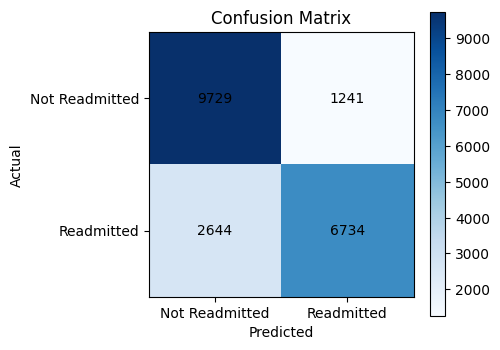

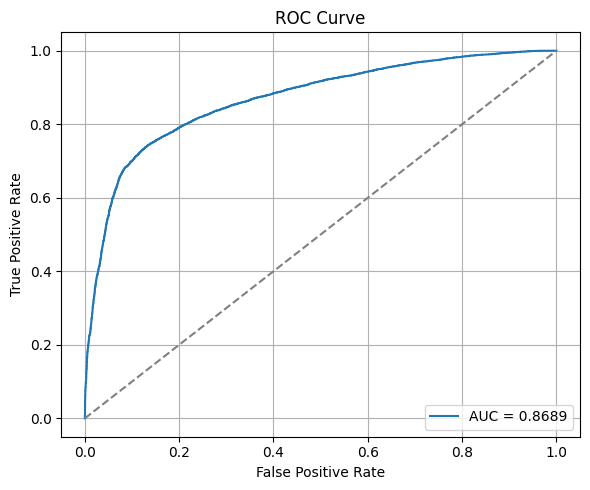

In [ ]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt

# === Load Data ===
df = pd.read_csv(r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\Data\FYP_Cleaned2.csv")
X = df.drop(columns=["readmitted"])
y = df["readmitted"]

# === Recreate Same Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Load Model ===
model = joblib.load(r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\BaseModels\catboost.pkl")

# === Predict on Test Set ===
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# === Print Evaluation ===
print("=== Evaluation on Test Set ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}\n")

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

print("=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# === Confusion Matrix Plot ===
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ['Not Readmitted', 'Readmitted'])
plt.yticks([0, 1], ['Not Readmitted', 'Readmitted'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# === ROC Curve ===
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


=== Evaluation on Test Set ===
Accuracy: 0.8085
Precision: 0.8484
Recall: 0.7118
F1 Score: 0.7741
ROC AUC Score: 0.8686

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.7834    0.8912    0.8339     10970
           1     0.8484    0.7118    0.7741      9378

    accuracy                         0.8085     20348
   macro avg     0.8159    0.8015    0.8040     20348
weighted avg     0.8134    0.8085    0.8063     20348

=== Confusion Matrix ===
[[9777 1193]
 [2703 6675]]


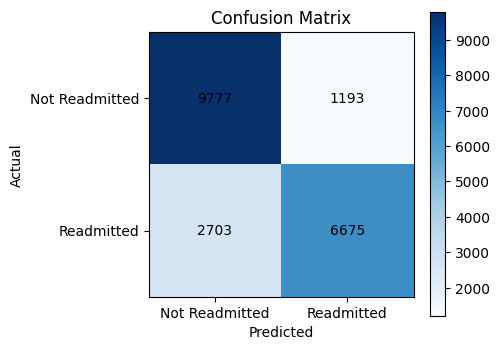

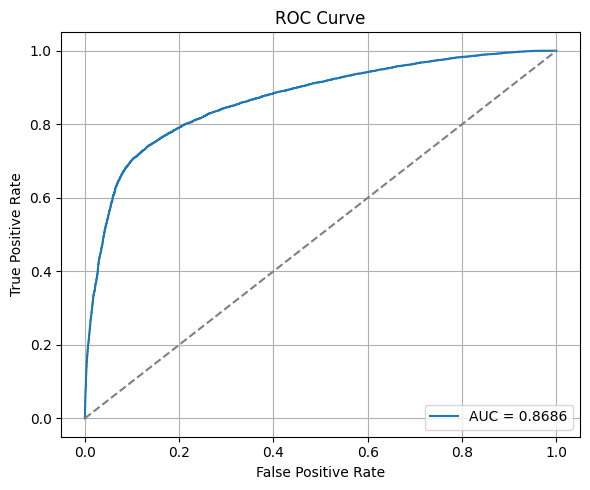

In [8]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt

# === Load Data ===
df = pd.read_csv(r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\Data\FYP_Cleaned2.csv")
X = df.drop(columns=["readmitted"])
y = df["readmitted"]

# === Recreate Same Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Load Model ===
model = joblib.load(r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\BaseModels\lightgbm.pkl")

# === Predict on Test Set ===
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# === Print Evaluation ===
print("=== Evaluation on Test Set ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}\n")

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

print("=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# === Confusion Matrix Plot ===
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ['Not Readmitted', 'Readmitted'])
plt.yticks([0, 1], ['Not Readmitted', 'Readmitted'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# === ROC Curve ===
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


=== Evaluation on Test Set ===
Accuracy: 0.8073
Precision: 0.8402
Recall: 0.7184
F1 Score: 0.7745
ROC AUC Score: 0.8666

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.7858    0.8832    0.8317     10970
           1     0.8402    0.7184    0.7745      9378

    accuracy                         0.8073     20348
   macro avg     0.8130    0.8008    0.8031     20348
weighted avg     0.8109    0.8073    0.8053     20348

=== Confusion Matrix ===
[[9689 1281]
 [2641 6737]]


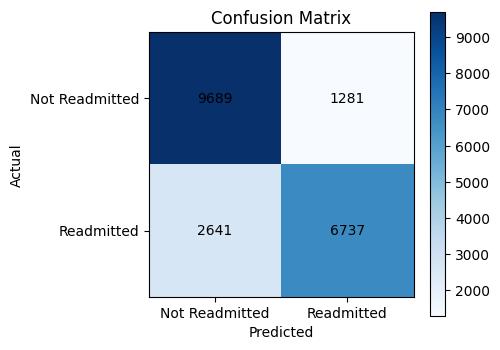

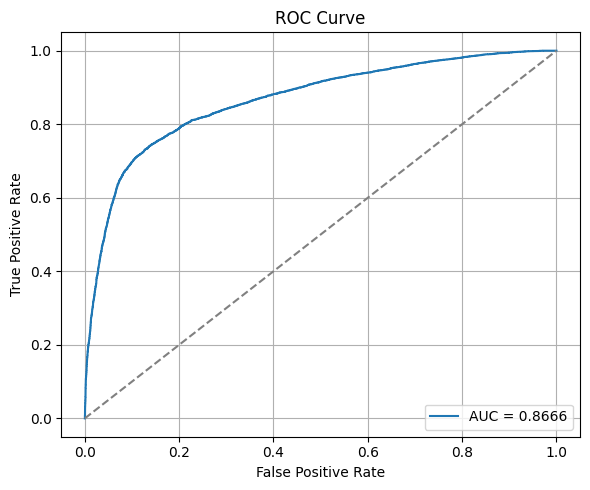

In [9]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt

# === Load Data ===
df = pd.read_csv(r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\Data\FYP_Cleaned2.csv")
X = df.drop(columns=["readmitted"])
y = df["readmitted"]

# === Recreate Same Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Load Model ===
model = joblib.load(r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\BaseModels\xgboost.pkl")

# === Predict on Test Set ===
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# === Print Evaluation ===
print("=== Evaluation on Test Set ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}\n")

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

print("=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# === Confusion Matrix Plot ===
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ['Not Readmitted', 'Readmitted'])
plt.yticks([0, 1], ['Not Readmitted', 'Readmitted'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# === ROC Curve ===
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


=== Evaluation on Test Set ===
Accuracy: 0.8070
Precision: 0.8527
Recall: 0.7025
F1 Score: 0.7703
ROC AUC Score: 0.8608

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.7790    0.8963    0.8335     10970
           1     0.8527    0.7025    0.7703      9378

    accuracy                         0.8070     20348
   macro avg     0.8158    0.7994    0.8019     20348
weighted avg     0.8129    0.8070    0.8044     20348

=== Confusion Matrix ===
[[9832 1138]
 [2790 6588]]


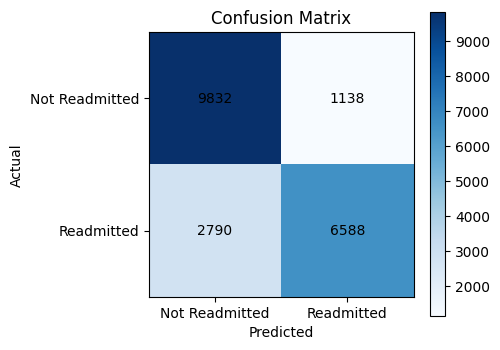

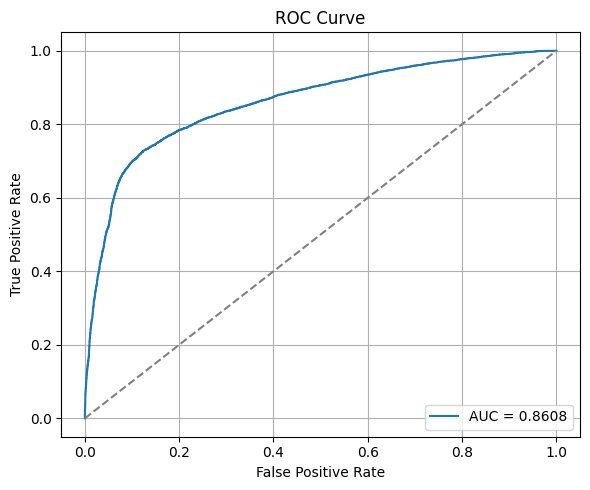

In [10]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt

# === Load Data ===
df = pd.read_csv(r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\Data\FYP_Cleaned2.csv")
X = df.drop(columns=["readmitted"])
y = df["readmitted"]

# === Recreate Same Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Load Model ===
model = joblib.load(r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\BaseModels\simpler_ann.pkl")

# === Predict on Test Set ===
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# === Print Evaluation ===
print("=== Evaluation on Test Set ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}\n")

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

print("=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# === Confusion Matrix Plot ===
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ['Not Readmitted', 'Readmitted'])
plt.yticks([0, 1], ['Not Readmitted', 'Readmitted'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# === ROC Curve ===
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


=== Evaluation on Test Set ===
Accuracy: 0.8034
Precision: 0.8354
Recall: 0.7140
F1 Score: 0.7700
ROC AUC Score: 0.8633

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.7825    0.8798    0.8283     10970
           1     0.8354    0.7140    0.7700      9378

    accuracy                         0.8034     20348
   macro avg     0.8090    0.7969    0.7991     20348
weighted avg     0.8069    0.8034    0.8014     20348

=== Confusion Matrix ===
[[9651 1319]
 [2682 6696]]


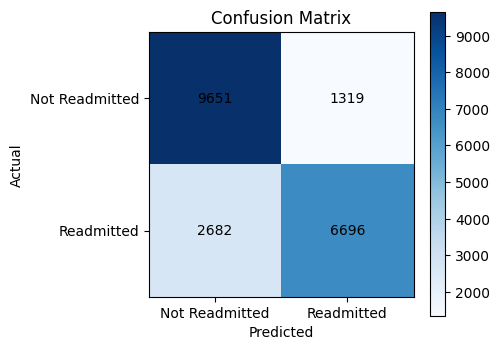

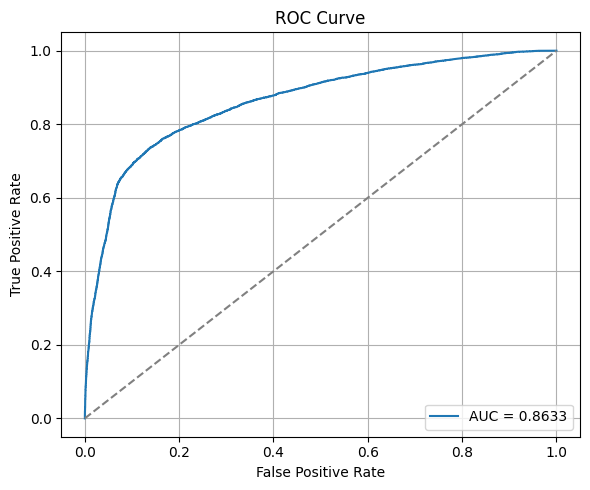

In [11]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt

# === Load Data ===
df = pd.read_csv(r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\Data\FYP_Cleaned2.csv")
X = df.drop(columns=["readmitted"])
y = df["readmitted"]

# === Recreate Same Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Load Model ===
model = joblib.load(r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\BaseModels\gradientboosting.pkl")

# === Predict on Test Set ===
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# === Print Evaluation ===
print("=== Evaluation on Test Set ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}\n")

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

print("=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# === Confusion Matrix Plot ===
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ['Not Readmitted', 'Readmitted'])
plt.yticks([0, 1], ['Not Readmitted', 'Readmitted'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# === ROC Curve ===
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


=== Evaluation on Test Set ===
Accuracy: 0.8096
Precision: 0.8481
Recall: 0.7150
F1 Score: 0.7759
ROC AUC Score: 0.8689

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.7852    0.8905    0.8345     10970
           1     0.8481    0.7150    0.7759      9378

    accuracy                         0.8096     20348
   macro avg     0.8166    0.8027    0.8052     20348
weighted avg     0.8142    0.8096    0.8075     20348

=== Confusion Matrix ===
[[9769 1201]
 [2673 6705]]


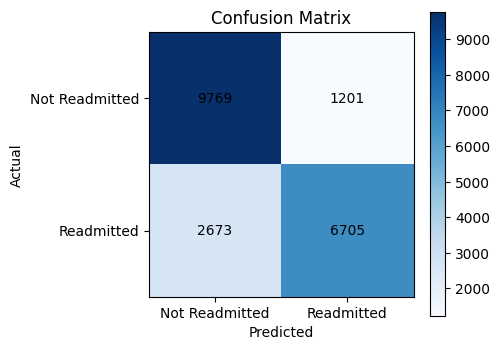

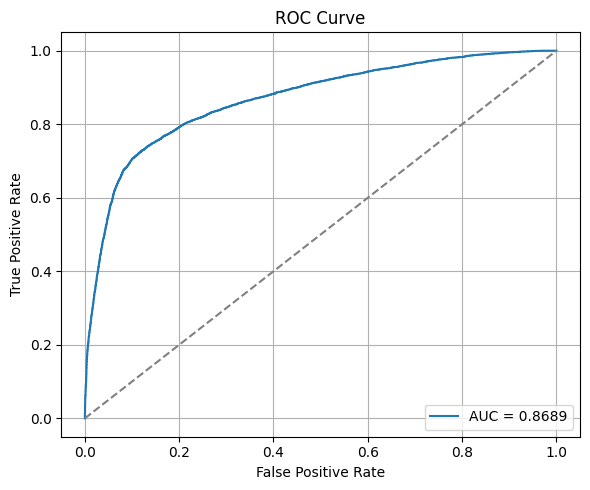

In [26]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt

# === Load Data ===
df = pd.read_csv(r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\Data\FYP_Cleaned2.csv")
X = df.drop(columns=["readmitted"])
y = df["readmitted"]

# === Recreate Same Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Load Model ===
model = joblib.load(r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\HypertunedModels\Lightgbm_Gridsearch.pkl")

# === Predict on Test Set ===
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# === Print Evaluation ===
print("=== Evaluation on Test Set ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}\n")

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

print("=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# === Confusion Matrix Plot ===
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ['Not Readmitted', 'Readmitted'])
plt.yticks([0, 1], ['Not Readmitted', 'Readmitted'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# === ROC Curve ===
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


=== Evaluation on Test Set ===
Accuracy: 0.8098
Precision: 0.8474
Recall: 0.7164
F1 Score: 0.7764
ROC AUC Score: 0.8692

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.7858    0.8897    0.8345     10970
           1     0.8474    0.7164    0.7764      9378

    accuracy                         0.8098     20348
   macro avg     0.8166    0.8030    0.8055     20348
weighted avg     0.8142    0.8098    0.8077     20348

=== Confusion Matrix ===
[[9760 1210]
 [2660 6718]]


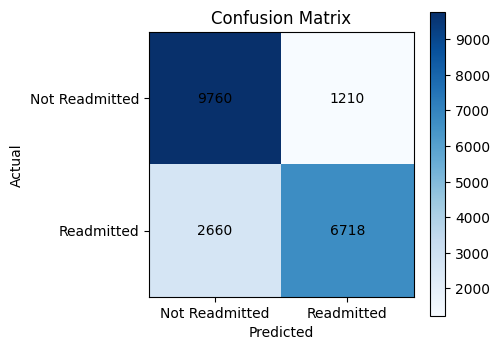

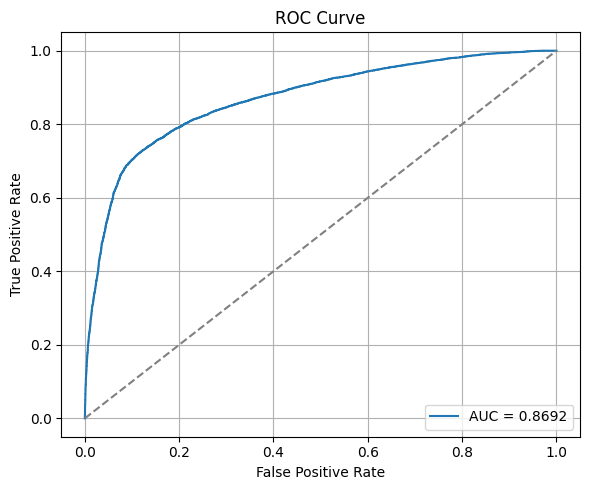

In [8]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt

# === Load Data ===
df = pd.read_csv(r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\Data\FYP_Cleaned2.csv")
X = df.drop(columns=["readmitted"])
y = df["readmitted"]

# === Recreate Same Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Load Model ===
model = joblib.load(r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\HypertunedModels\Lightgbm_Randomsearch.pkl")

# === Predict on Test Set ===
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# === Print Evaluation ===
print("=== Evaluation on Test Set ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}\n")

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

print("=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# === Confusion Matrix Plot ===
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ['Not Readmitted', 'Readmitted'])
plt.yticks([0, 1], ['Not Readmitted', 'Readmitted'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# === ROC Curve ===
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


=== Evaluation on Test Set ===
Accuracy: 0.8096
Precision: 0.8481
Recall: 0.7150
F1 Score: 0.7759
ROC AUC Score: 0.8689

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.7852    0.8905    0.8345     10970
           1     0.8481    0.7150    0.7759      9378

    accuracy                         0.8096     20348
   macro avg     0.8166    0.8027    0.8052     20348
weighted avg     0.8142    0.8096    0.8075     20348

=== Confusion Matrix ===
[[9769 1201]
 [2673 6705]]


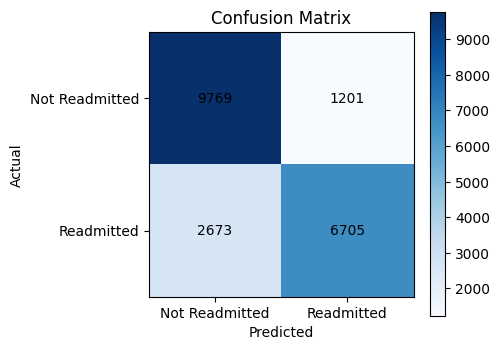

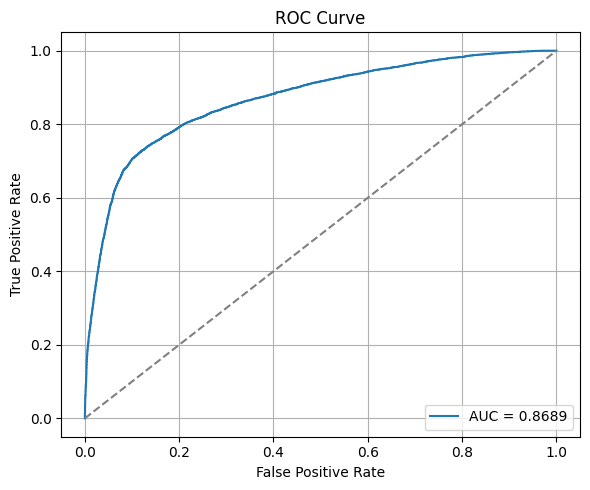

In [9]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt

# === Load Data ===
df = pd.read_csv(r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\Data\FYP_Cleaned2.csv")
X = df.drop(columns=["readmitted"])
y = df["readmitted"]

# === Recreate Same Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Load Model ===
model = joblib.load(r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\HypertunedModels\Lightgbm_GridSearch.pkl")

# === Predict on Test Set ===
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# === Print Evaluation ===
print("=== Evaluation on Test Set ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}\n")

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

print("=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# === Confusion Matrix Plot ===
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ['Not Readmitted', 'Readmitted'])
plt.yticks([0, 1], ['Not Readmitted', 'Readmitted'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# === ROC Curve ===
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


=== Evaluation on Test Set ===
Accuracy: 0.8095
Precision: 0.8457
Recall: 0.7175
F1 Score: 0.7763
ROC AUC Score: 0.8683

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.7862    0.8881    0.8340     10970
           1     0.8457    0.7175    0.7763      9378

    accuracy                         0.8095     20348
   macro avg     0.8159    0.8028    0.8052     20348
weighted avg     0.8136    0.8095    0.8075     20348

=== Confusion Matrix ===
[[9742 1228]
 [2649 6729]]


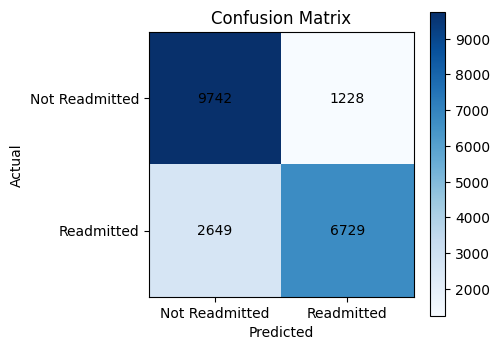

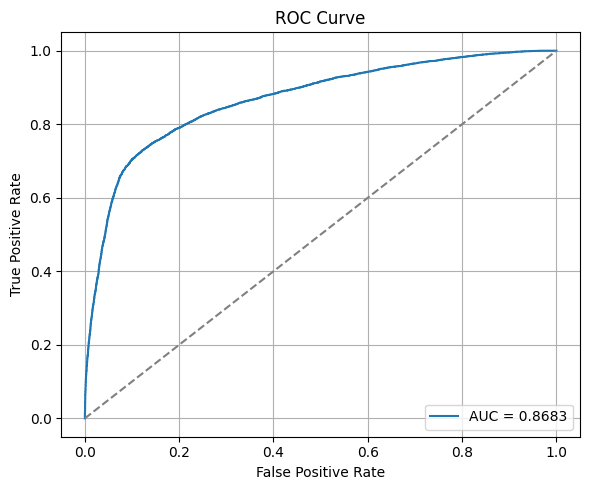

In [10]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt

# === Load Data ===
df = pd.read_csv(r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\Data\FYP_Cleaned2.csv")
X = df.drop(columns=["readmitted"])
y = df["readmitted"]

# === Recreate Same Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Load Model ===
model = joblib.load(r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\HypertunedModels\XGBoost_Gridsearch.pkl")

# === Predict on Test Set ===
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# === Print Evaluation ===
print("=== Evaluation on Test Set ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}\n")

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

print("=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# === Confusion Matrix Plot ===
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ['Not Readmitted', 'Readmitted'])
plt.yticks([0, 1], ['Not Readmitted', 'Readmitted'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# === ROC Curve ===
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


=== Evaluation on Test Set ===
Accuracy: 0.8097
Precision: 0.8459
Recall: 0.7179
F1 Score: 0.7766
ROC AUC Score: 0.8689

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.7864    0.8882    0.8342     10970
           1     0.8459    0.7179    0.7766      9378

    accuracy                         0.8097     20348
   macro avg     0.8162    0.8030    0.8054     20348
weighted avg     0.8139    0.8097    0.8077     20348

=== Confusion Matrix ===
[[9744 1226]
 [2646 6732]]


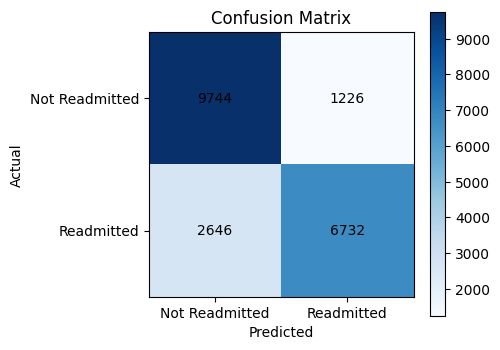

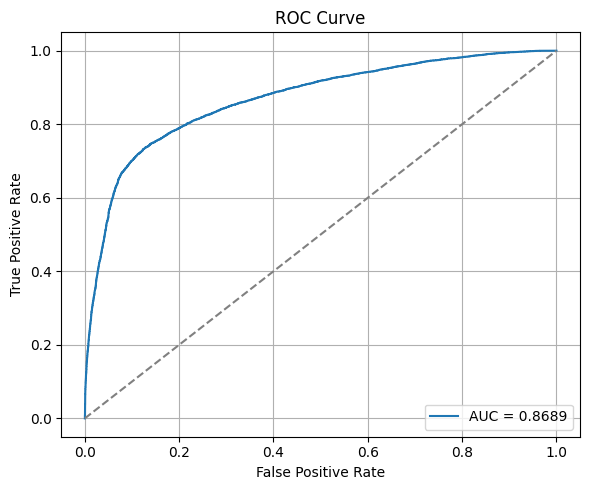

In [12]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt

# === Load Data ===
df = pd.read_csv(r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\Data\FYP_Cleaned2.csv")
X = df.drop(columns=["readmitted"])
y = df["readmitted"]

# === Recreate Same Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Load Model ===
model = joblib.load(r"C:\Users\MMU50\OneDrive\Desktop\Y3S2\FYP II\Readmission_System\HypertunedModels\Catboost_Randomsearch.pkl")

# === Predict on Test Set ===
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# === Print Evaluation ===
print("=== Evaluation on Test Set ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}\n")

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

print("=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# === Confusion Matrix Plot ===
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ['Not Readmitted', 'Readmitted'])
plt.yticks([0, 1], ['Not Readmitted', 'Readmitted'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# === ROC Curve ===
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()
